This tutorial trains a Transformer model to translate Chinese to English using pre-trained model BERT as encoder in tensorflow 2.0.

You will install tensorflow 2.0 first:
```bash
pip install tensorflow-gpu==2.0.0-beta1
pip install tensorflow-datasets
pip install bert-for-tf2
```

And download the BERT chinese pre-trained model:
```bash
wget https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip
```

##Prepare the package requirements.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-beta1
!pip install tensorflow-datasets
!pip install bert-for-tf2

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt
import collections
import unicodedata

import os
from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights


     |████████████████████████████████| 348.9MB 46kB/s 
     |████████████████████████████████| 501kB 48.9MB/s 
     |████████████████████████████████| 3.1MB 45.3MB/s 
     |████████████████████████████████| 686kB 41.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/dd/38/d7/ced0f6a8658d616e2db8243868de392e2a2e9a01e62f16ad1b
  Stored in directory: /root/.cache/pip/wheels/33/66/2a/5593608fbe4cbcea004c3f2432f3b00f01430d9bb218bb23c6
  Stored in directory: /root/.cache/pip/wheels/3b/3b/0c/3c434295eb5f16ffaf638eff3ce0698adbc161107cd063f016
Successfully built bert-for-tf2 py-params params-flow


In [0]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [0]:
if not os.path.exists('chinese_L-12_H-768_A-12'):
  !wget https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip
  !unzip chinese_L-12_H-768_A-12

--2019-06-26 00:35:27--  https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.161.80, 2404:6800:4004:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.161.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381892918 (364M) [application/zip]
Saving to: ‘chinese_L-12_H-768_A-12.zip’

chinese_L-12_H-768_ 100%[===================>] 364.20M   291MB/s    in 1.3s    

2019-06-26 00:35:28 (291 MB/s) - ‘chinese_L-12_H-768_A-12.zip’ saved [381892918/381892918]

Archive:  chinese_L-12_H-768_A-12.zip
   creating: chinese_L-12_H-768_A-12/
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: chinese_L-12_H-768_A-12/vocab.txt  
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: chinese_L-12_H-768_A-12/bert_config.json  


## Add BERT tokenization

In [0]:
def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if isinstance(text, str):
        return text
    elif isinstance(text, bytes):
        return text.decode("utf-8", "ignore")
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.io.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

def convert_by_vocab(vocab, items):
    """Converts a sequence of [tokens|ids] using the vocab."""
    output = []
    for item in items:
        output.append(vocab[item])
    return output

class FullTokenizer(object):
    """Runs end-to-end tokenziation."""

    def __init__(self, vocab_file, do_lower_case=True):
        self.vocab = load_vocab(vocab_file)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

    def tokenize(self, text):
        split_tokens = []
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)

        return split_tokens
    
    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

    def convert_ids_to_tokens(self, ids):
        return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True):
        """Constructs a BasicTokenizer.
    
        Args:
          do_lower_case: Whether to lower case the input.
        """
        self.do_lower_case = do_lower_case

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = convert_to_unicode(text)
        text = self._clean_text(text)

        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        text = self._tokenize_chinese_chars(text)

        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenziation."""

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.
    
        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.
    
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
    
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer.
    
        Returns:
          A list of wordpiece tokens.
        """

        text = convert_to_unicode(text)

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens

def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False


## Setup input pipleline

Use TFDS to load the wmt2019 zh-en translation dataset.

In [0]:
config = tfds.translate.wmt.WmtConfig(
    description="WMT 2019 translation task dataset.",
    version="0.0.3",
    language_pair=("zh", "en"),
    subsets={
        tfds.Split.TRAIN: ["newscommentary_v13"],
        tfds.Split.VALIDATION: ["newsdev2017"],
    }
)

builder = tfds.builder("wmt_translate", config=config)
print(builder.info.splits)
builder.download_and_prepare()
datasets = builder.as_dataset(as_supervised=True)
print('datasets is {}'.format(datasets))


W0626 00:35:36.399345 140703702083456 dataset_builder.py:540] Using custom data configuration zh-en


{}


W0626 00:36:15.390593 140703702083456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:247: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0626 00:36:18.650468 140703702083456 dataset_builder.py:727] Statistics not present in the dataset. TFDS is not able to load the total number of examples, so using the subsplit API may not provide precise subsplits.


W0626 00:37:34.540203 140703702083456 dataset_builder.py:727] Statistics not present in the dataset. TFDS is not able to load the total number of examples, so using the subsplit API may not provide precise subsplits.



Dataset wmt_translate downloaded and prepared to /root/tensorflow_datasets/wmt_translate/zh-en/0.0.3. Subsequent calls will reuse this data.
datasets is {'train': <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>, 'validation': <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>}


In [0]:
train_examples = datasets['train']
val_examples = datasets['validation']


In [0]:
for zh, en in train_examples.take(1):
  print(tf.compat.as_text(zh.numpy()))
  print(tf.compat.as_text(en.numpy()))

虽然继承了祖荫，但朴槿惠已经证明了自己是个机敏而老练的政治家——她历经20年才爬上韩国大国家党最高领导层并成为全国知名人物。
While Park derives some of her power from her family pedigree, she has proven to be an astute and seasoned politician –&nbsp;one who climbed the Grand National Party’s leadership ladder over the last two decades to emerge as a national figure.


Create a custom subwords tokenizer from the training dataset for the decoder.

In [0]:
vocab_file = 'vocab_en'
if os.path.isfile(vocab_file + '.subwords'):
  tokenizer_en = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_file)
else: 
  tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for zh, en in train_examples), target_vocab_size=2 ** 13)
  tokenizer_en.save_to_file('vocab_en')
  
sample_string = 'Transformer is awesome.'
tokenized_string = tokenizer_en.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))


2877 ----> Trans
466 ----> former 
9 ----> is 
3502 ----> aw
157 ----> es
1805 ----> ome
8013 ----> .


The encoder uses BERT tokenizer.

In [0]:

tokenizer_zh = FullTokenizer(
        vocab_file='chinese_L-12_H-768_A-12/vocab.txt', do_lower_case=True)

test_tokens = tokenizer_zh.tokenize('埃隆·马斯克(Elon Musk)创建了特斯拉')
test_ids = tokenizer_zh.convert_tokens_to_ids(['[CLS]'] + test_tokens + ['[SEP]'])
print(test_ids)
print(tokenizer_zh.convert_ids_to_tokens(test_ids))

[101, 1812, 7384, 185, 7716, 3172, 1046, 113, 10245, 8224, 11677, 8998, 114, 1158, 2456, 749, 4294, 3172, 2861, 102]
['[CLS]', '埃', '隆', '·', '马', '斯', '克', '(', 'el', '##on', 'mu', '##sk', ')', '创', '建', '了', '特', '斯', '拉', '[SEP]']


Add a start and end token to the input and target.

In [0]:
MAX_SEQ_LENGTH = 128


def encode(zh, en, seq_length=MAX_SEQ_LENGTH):
    tokens_zh = tokenizer_zh.tokenize(tf.compat.as_text(zh.numpy()))
    lang1 = tokenizer_zh.convert_tokens_to_ids(['[CLS]'] + tokens_zh + ['[SEP]'])
    if len(lang1) < seq_length:
      lang1 = lang1 + list(np.zeros(seq_length - len(lang1), 'int32'))
      
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        tf.compat.as_text(en.numpy())) + [tokenizer_en.vocab_size + 1]
    if len(lang2) < seq_length:
      lang2 = lang2 + list(np.zeros(seq_length - len(lang2), 'int32'))
      
    return lang1, lang2


In [0]:
def filter_max_length(x, y, max_length=MAX_SEQ_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

Encode texts into integers.

In [0]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

train_dataset = train_examples.map(
    lambda zh, en: tf.py_function(encode, [zh, en], [tf.int32, tf.int32]))
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]), drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(
    lambda zh, en: tf.py_function(encode, [zh, en], [tf.int32, tf.int32]))
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))


## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


In [0]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)

    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [0]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


## Scaled dot product attention

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
      
    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


## Multi-head attention

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


In [0]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 768))  # (batch_size, encoder_sequence, d_model)
q = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=q, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


## Encoder Layer and Encoder

Use bert as encoder. The output shape is (batch_size, input_seq_len, d_model).

In [0]:

def build_encoder(config_file):
    with tf.io.gfile.GFile(config_file, "r") as reader:
        stock_params = StockBertConfig.from_json_string(reader.read())
        bert_params = stock_params.to_bert_model_layer_params()

    return BertModelLayer.from_params(bert_params, name="bert")


## Decoder Layer and Decoder

Each decoder layer consists of sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)

2. Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublaye

3. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


In [0]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_encoder_output = tf.random.uniform((64, 128, 768))

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


TensorShape([64, 50, 512])

The Decoder consists of: 1. Output Embedding 2. Positional Encoding 3. N decoder layers


In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


In [0]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 128]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Config(object):
  def __init__(self, num_layers, d_model, dff, num_heads):
    self.num_layers = num_layers
    self.d_model = d_model
    self.dff = dff
    self.num_heads = num_heads

In [0]:
from bert.loader import map_to_stock_variable_name


class Transformer(tf.keras.Model):
  def __init__(self, config,
               target_vocab_size, 
               bert_config_file,
               bert_training=False, 
               rate=0.1,
               name='transformer'):
      super(Transformer, self).__init__(name=name)

      self.encoder = build_encoder(config_file=bert_config_file)
      self.encoder.trainable = bert_training

      self.decoder = Decoder(config.num_layers, config.d_model, 
                             config.num_heads, config.dff, target_vocab_size, rate)

      self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def load_stock_weights(self, bert: BertModelLayer, ckpt_file):
      assert isinstance(bert, BertModelLayer), "Expecting a BertModelLayer instance as first argument"
      assert tf.compat.v1.train.checkpoint_exists(ckpt_file), "Checkpoint does not exist: {}".format(ckpt_file)
      ckpt_reader = tf.train.load_checkpoint(ckpt_file)

      bert_prefix = 'transformer/bert'

      weights = []
      for weight in bert.weights:
          stock_name = map_to_stock_variable_name(weight.name, bert_prefix)
          if ckpt_reader.has_tensor(stock_name):
              value = ckpt_reader.get_tensor(stock_name)
              weights.append(value)
          else:
              raise ValueError("No value for:[{}], i.e.:[{}] in:[{}]".format(
                  weight.name, stock_name, ckpt_file))
      bert.set_weights(weights)
      print("Done loading {} BERT weights from: {} into {} (prefix:{})".format(
          len(weights), ckpt_file, bert, bert_prefix))

  def restore_encoder(self, bert_ckpt_file):
      # loading the original pre-trained weights into the BERT layer:
      self.load_stock_weights(self.encoder, bert_ckpt_file)

  def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp, training=self.encoder.trainable)  # (batch_size, inp_seq_len, d_model)

      # dec_output.shape == (batch_size, tar_seq_len, d_model)
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

      return final_output, attention_weights


## Set hyperparameters

To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.

In [0]:
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1
config = Config(num_layers=6, d_model=256, dff=1024, num_heads=8)

In [0]:
MODEL_DIR = "chinese_L-12_H-768_A-12"
bert_config_file = os.path.join(MODEL_DIR, "bert_config.json")
bert_ckpt_file = os.path.join(MODEL_DIR, "bert_model.ckpt")

transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
tar_inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
fn_out, _ = transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
print(tar_inp.shape) # (batch_size, tar_seq_len) 
print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size) 

# init bert pre-trained weights
transformer.restore_encoder(bert_ckpt_file)


W0626 00:41:07.395809 140703702083456 deprecation.py:323] From <ipython-input-27-b176af2b20fd>:24: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(64, 128)
(64, 128, 8225)
Done loading 196 BERT weights from: chinese_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7ff75ca86e48> (prefix:transformer/bert)


In [0]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        multiple                  101675520 
_________________________________________________________________
decoder_1 (Decoder)          multiple                  9999104   
_________________________________________________________________
dense_94 (Dense)             multiple                  2113825   
Total params: 113,788,449
Trainable params: 12,112,929
Non-trainable params: 101,675,520
_________________________________________________________________


## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [0]:
learning_rate = CustomSchedule(config.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

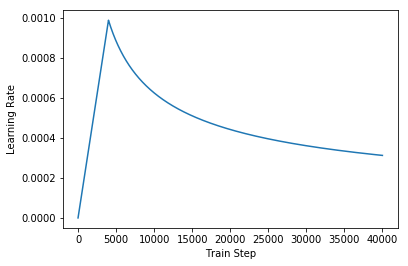

In [0]:
temp_learning_rate_schedule = CustomSchedule(config.d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [0]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')


## Training and checkpointing

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')


During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.



In [0]:
def create_masks(inp, tar):
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [0]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)


Chinese is used as the input language and English is the target language.

In [40]:

EPOCHS = 4

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> chinese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 500 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


W0626 00:41:08.328056 140700424128256 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0626 00:41:08.330051 140700424128256 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0626 00:41:08.348146 140700432520960 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0626 00:41:08.350182 140700432520960 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0626 00:41:08.354208 140700432520960 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0626 00:42:36.146764 140703702083456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where 

Epoch 1 Batch 0 Loss 2.6266 Accuracy 0.0001
Epoch 1 Batch 500 Loss 1.9671 Accuracy 0.0167
Epoch 1 Batch 1000 Loss 1.7554 Accuracy 0.0311
Epoch 1 Batch 1500 Loss 1.6164 Accuracy 0.0402
Epoch 1 Batch 2000 Loss 1.5107 Accuracy 0.0474
Epoch 1 Batch 2500 Loss 1.4223 Accuracy 0.0536
Epoch 1 Batch 3000 Loss 1.3485 Accuracy 0.0590
Epoch 1 Batch 3500 Loss 1.2875 Accuracy 0.0636
Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1
Epoch 1 Loss 1.2419 Accuracy 0.0672
Time taken for 1 epoch: 3596.885156393051 secs

Epoch 2 Batch 0 Loss 0.9382 Accuracy 0.0941
Epoch 2 Batch 500 Loss 0.8513 Accuracy 0.0995
Epoch 2 Batch 1000 Loss 0.8361 Accuracy 0.1017
Epoch 2 Batch 1500 Loss 0.8205 Accuracy 0.1037
Epoch 2 Batch 2000 Loss 0.8060 Accuracy 0.1054
Epoch 2 Batch 2500 Loss 0.7922 Accuracy 0.1070
Epoch 2 Batch 3000 Loss 0.7813 Accuracy 0.1086
Epoch 2 Batch 3500 Loss 0.7711 Accuracy 0.1100
Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-2
Epoch 2 Loss 0.7630 Accuracy 0.1112
Time taken for 1

## Evaluate

The following steps are used for evaluation:

- Encode the input sentence using the Portuguese tokenizer (tokenizer_pt). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.

- The decoder input is the start token == tokenizer_en.vocab_size.

- Calculate the padding masks and the look ahead masks.

- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).

- Select the last word and calculate the argmax of that.

- Concatentate the predicted word to the decoder input as pass it to the decoder.

- In this approach, the decoder predicts the next word based on the previous words it predicted.

In [0]:
def encode_zh(zh):
    tokens_zh = tokenizer_zh.tokenize(zh)
    lang1 = tokenizer_zh.convert_tokens_to_ids(['[CLS]'] + tokens_zh + ['[SEP]'])

    return lang1


In [42]:
sentence_ids = encode_zh("我爱你啊")
print(tokenizer_zh.convert_ids_to_tokens(sentence_ids))

['[CLS]', '我', '爱', '你', '啊', '[SEP]']


In [0]:
def evaluate(transformer, inp_sentence):
    # normalize input sentence
    inp_sentence = encode_zh(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_SEQ_LENGTH):
        combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_en.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [0]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence_ids = encode_zh(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10, 'family' : 'DFKai-SB'}

        ax.set_xticks(range(len(sentence_ids)))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(
            tokenizer_zh.convert_ids_to_tokens(sentence_ids),
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

        
    plt.tight_layout()
    plt.show()


In [0]:
def translate(transformer, sentence, plot=''):
    result, attention_weights = evaluate(transformer, sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)


In [51]:
translate(transformer, '虽然继承了祖荫，但朴槿惠已经证明了自己是个机敏而老练的政治家——她历经20年才爬上韩国大国家党最高领导层并成为全国知名人物。')
print('Real translation: While Park derives some of her power from her family pedigree, she has proven to be an astute and seasoned politician –&nbsp;one who climbed the Grand National Party’s leadership ladder over the last two decades to emerge as a national figure.')

Input: 虽然继承了祖荫，但朴槿惠已经证明了自己是个机敏而老练的政治家——她历经20年才爬上韩国大国家党最高领导层并成为全国知名人物。
Predicted translation: While inherited her father, Park has proven that she is a brave and al-keal – a politician who has been able to topple the country’s largest party and become a national leader.
Real translation: While Park derives some of her power from her family pedigree, she has proven to be an astute and seasoned politician –&nbsp;one who climbed the Grand National Party’s leadership ladder over the last two decades to emerge as a national figure.


In [59]:
translate(transformer, "我爱你是一件幸福的事情。")

Input: 我爱你是一件幸福的事情。
Predicted translation: I love you are a blessing.


## Save weights

In [0]:
transformer.save_weights('bert_nmt_ckpt')

In [49]:

new_transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
fn_out, _ = new_transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
new_transformer.load_weights('bert_nmt_ckpt')

translate(new_transformer, '我爱你')

Input: 是的，从某种程度上来看，我们可以通过现代技术或者录像回放来审视有争议的判罚决定，以此来解决这一问题。
Predicted translation: Yes, in some ways, we can use modern techniques or video video to review contentious decisions, so that it is possible to address the problem.


## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer with BERT.

Try using a different dataset to train the transformer. Futhermore, you can implement beam search to get better predictions.

At last, you can copy pre-trained weights and relevant files to your drive.

In [53]:
# 运行此单元格即可装载您的 Google 云端硬盘。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp bert_nmt_ckpt* "./drive/My Drive/models/nmt/"
!cp vocab_en* "./drive/My Drive/models/nmt/"